# The COVID-19 trend analysis and prediction in Canada (Liu, Trinh. 2020)
# COMP 432 Machine Learning G17

##### Analysis based on:
##### https://www.kaggle.com/mabusalah/brentoilprices
##### https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
##### https://github.com/ishaberry/Covid19Canada/tree/master/timeseries_canada

In [ ]:
!pip install wget

!pip install pmdarima

!pip install pyramid-arima

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3655d78788ebae240d13890ea3a6796e61a76156da9b8efe58ad40607c4ba003
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 1.5MB 4.2MB/s 
     |████████████████████████████████| 9.5MB 6.2MB/s 
     |████████████████████████████████| 2.1MB 39.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
     |████████████████████████████████| 604kB 5.8MB/s 


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree        # For DecisionTreeClassifier class
import sklearn.ensemble    # For AdaBoostClassifier class
import sklearn.datasets    # For make_gaussian_quantiles
import sklearn.metrics     # For accuracy_score
import sklearn.svm             # For SVC class
import sklearn.preprocessing   # For scale function
import pandas as pd
import statistics
import pmdarima as pm
import wget # For downloading online files
import statsmodels.api as sm

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller # For stats and verify our model's prediction
from numpy import log
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split


Here we download all our datasets to be processed

In [ ]:
cases_timeseries_canada_csv = wget.download('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_canada/cases_timeseries_canada.csv')
mortality_timeseries_canada_csv = wget.download('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_canada/mortality_timeseries_canada.csv')
recovered_timeseries_canada_csv = wget.download('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_canada/recovered_timeseries_canada.csv')
TemperatureOct2020_csv= wget.download('https://raw.githubusercontent.com/changlmasaki/temp_wind_oct_2020/main/TemperatureOct2020.csv')

In [ ]:
# Cases of COVID-19
startDateTrain = '2020-03-08'
endDateTrain = '2020-09-30'

df_cases = pd.read_csv('/content/cases_timeseries_canada.csv')
df_cases['date_report'] = pd.to_datetime(df_cases['date_report'], dayfirst=True)
df_cases = df_cases[(df_cases['date_report'] > startDateTrain)]
df_cases_weekly = df_cases.groupby(pd.Grouper(key='date_report', freq='W')).sum()

X_train_cases = df_cases_weekly.index
y_train_cases = df_cases_weekly['cases']

print(X_train_cases)
print(y_train_cases)

DatetimeIndex(['2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14', '2020-06-21', '2020-06-28',
               '2020-07-05', '2020-07-12', '2020-07-19', '2020-07-26',
               '2020-08-02', '2020-08-09', '2020-08-16', '2020-08-23',
               '2020-08-30', '2020-09-06', '2020-09-13', '2020-09-20',
               '2020-09-27', '2020-10-04', '2020-10-11', '2020-10-18',
               '2020-10-25', '2020-11-01', '2020-11-08', '2020-11-15',
               '2020-11-22', '2020-11-29', '2020-12-06'],
              dtype='datetime64[ns]', name='date_report', freq='W-SUN')
date_report
2020-03-15      274
2020-03-22     1130
2020-03-29     4848
2020-04-05     9593
2020-04-12     9145
2020-04-19    10953
2020-04-26    11836
2020-05-03    12458
2020-05-10     9624
2020-05-17     8254
2020-05-24     7809

In [ ]:
#Make sure we have no null values
print(df_cases.isnull().values.any())

False


In [ ]:
#Let us split the date into year, month and week to explore trends more in depth later on
df_cases['year']=df_cases['date_report'].dt.year
df_cases['month']=df_cases['date_report'].dt.month
df_cases['week']=df_cases['date_report'].dt.week

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
#Trends for January to October
train_cases = df_cases[(df_cases['date_report'] > startDateTrain) & (df_cases['date_report'] <= endDateTrain)]

print(train_cases)

    province date_report  cases  cumulative_cases  year  month  week
44    Canada  2020-03-09     19                86  2020      3    11
45    Canada  2020-03-10      9                95  2020      3    11
46    Canada  2020-03-11     21               116  2020      3    11
47    Canada  2020-03-12     40               156  2020      3    11
48    Canada  2020-03-13     42               198  2020      3    11
..       ...         ...    ...               ...   ...    ...   ...
245   Canada  2020-09-26   1246            153817  2020      9    39
246   Canada  2020-09-27   1411            155228  2020      9    39
247   Canada  2020-09-28   2243            157471  2020      9    40
248   Canada  2020-09-29   1669            159140  2020      9    40
249   Canada  2020-09-30   1816            160956  2020      9    40

[206 rows x 7 columns]


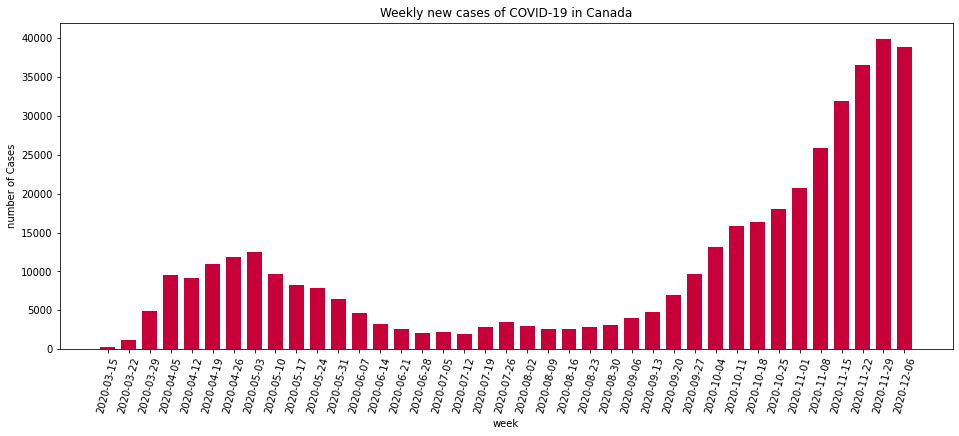

In [ ]:
#Visualize the data for each data type
plt.figure(figsize=(16,6))
plt.bar(X_train_cases, y_train_cases, width=5, color='#C70039')
plt.xticks(X_train_cases, X_train_cases.strftime("%Y-%m-%d"), rotation=75)
plt.title('Weekly new cases of COVID-19 in Canada') 
plt.xlabel('week', size=10)
plt.ylabel('number of Cases', size=10)
plt.show()

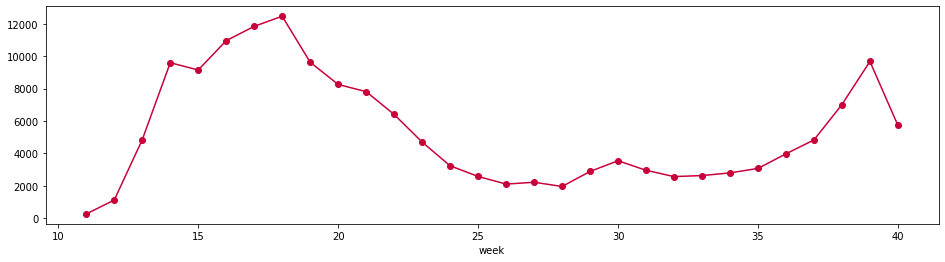

In [ ]:
#Weekly visualization
plt.figure(figsize=(16,4))
weeklyCases=train_cases.groupby(["week"])['cases'].sum()
weeklyCases.plot(marker="o", c='#C70039')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



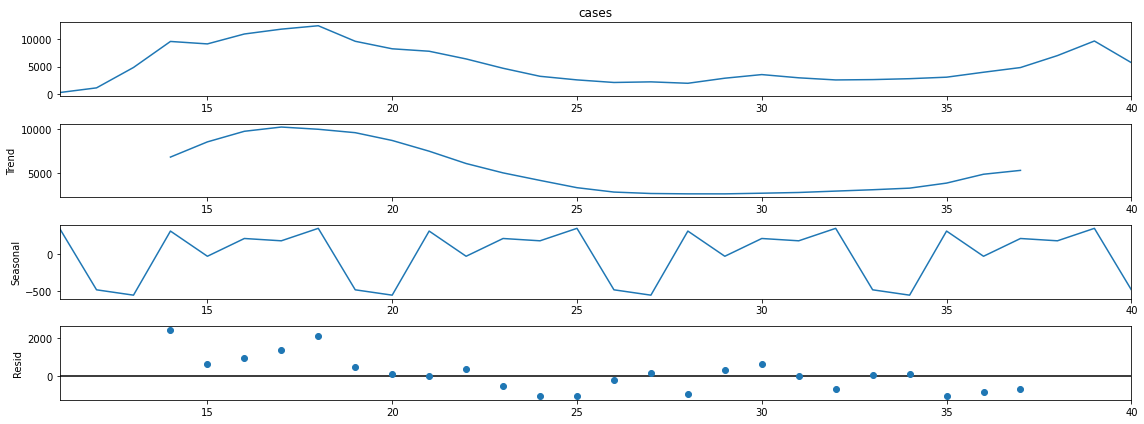

In [ ]:
#Decompose into three distinct components: trend, seasonality, and noise.

#Cases
rcParams['figure.figsize'] = 16, 6
#trend resulting from the convolution is linear least-squares extrapolated on both ends
# period/freq is 1
decomposition = sm.tsa.seasonal_decompose(weeklyCases, freq=7, model='additive')
fig = decomposition.plot()

In [ ]:
startDateTest = '2020-10-01'
endDateTest = '2020-10-31'

test_cases = df_cases[(df_cases['date_report'] >= startDateTest) & (df_cases['date_report'] <= endDateTest)]

print(test_cases)

    province date_report  cases  cumulative_cases  year  month  week
250   Canada  2020-10-01   1821            162777  2020     10    40
251   Canada  2020-10-02   2121            164898  2020     10    40
252   Canada  2020-10-03   1801            166699  2020     10    40
253   Canada  2020-10-04   1609            168308  2020     10    40
254   Canada  2020-10-05   2910            171218  2020     10    41
255   Canada  2020-10-06   2380            173598  2020     10    41
256   Canada  2020-10-07   1859            175457  2020     10    41
257   Canada  2020-10-08   2476            177933  2020     10    41
258   Canada  2020-10-09   2531            180464  2020     10    41
259   Canada  2020-10-10   2118            182582  2020     10    41
260   Canada  2020-10-11   1600            184182  2020     10    41
261   Canada  2020-10-12   1732            185914  2020     10    42
262   Canada  2020-10-13   3414            189328  2020     10    42
263   Canada  2020-10-14   2549   

In [ ]:
d={'ds':train_cases['date_report'],'y':train_cases['cases']}
df_pred=pd.DataFrame(data=d)
model1 = Prophet(daily_seasonality=True, weekly_seasonality=True)
model1.fit(df_pred)
futureCases = model1.make_future_dataframe(periods=31) # we try to predict 31 days
forecastCases = model1.predict(futureCases)
forecastCasesNov = forecastCases[(forecastCases['ds'] >= startDateTest) & (forecastCases['ds'] <= endDateTest)]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<Figure size 1152x432 with 0 Axes>

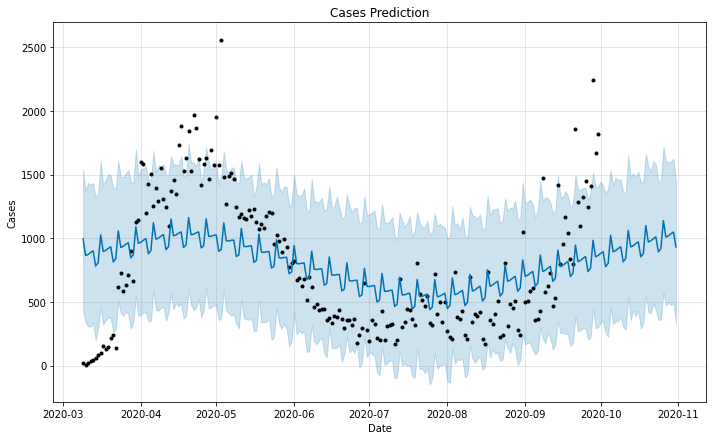

In [ ]:
plt.figure(figsize=(16, 6))
model1.plot(forecastCases, xlabel = 'Date', ylabel = 'Cases')
plt.title('Cases Prediction');

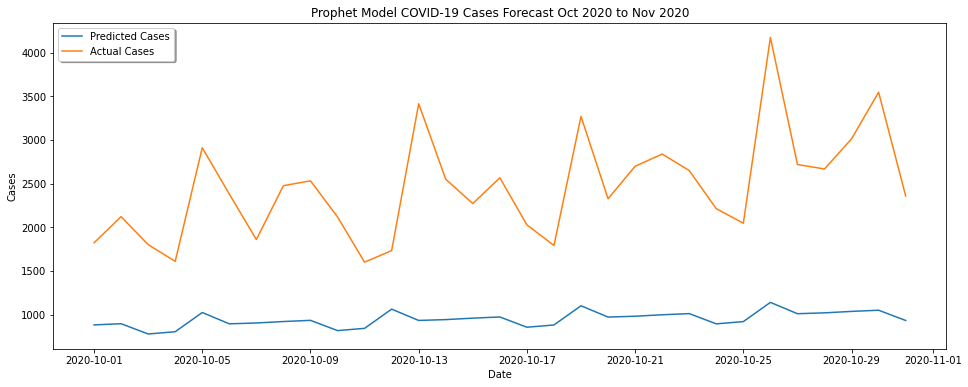

In [ ]:
fig, ax = plt.subplots()

ax.plot(forecastCasesNov['ds'], forecastCasesNov['yhat'], label='Predicted Cases')
ax.plot(test_cases['date_report'], test_cases['cases'], label='Actual Cases')
legend = ax.legend(loc='upper left', shadow=True)
plt.title('Prophet Model COVID-19 Cases Forecast Oct 2020 to Nov 2020')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [ ]:
# Cases
observedCases=test_cases['cases'].iloc[1:]
predictedCases=forecastCasesNov['yhat'].iloc[1:]

observedCases.reset_index(drop=True, inplace=True)
predictedCases.reset_index(drop=True, inplace=True)

pred_err_cases=[]
pred_err_recovered=[]
pred_err_mortality=[]

# Loop through each observeds vs predicted values
for count in range(len(observedCases)-1):
    err = predictedCases[count] - observedCases[count]
    pred_err_cases.append(err)

In [ ]:
#Mean relative to absolute error
maeCasesProphet = statistics.mean(map(abs,pred_err_cases))
print('Mean Absolute Error Cases = %.3f' % maeCasesProphet)

true_y_arr = test_cases['cases'].to_numpy()
pred_y_arr = predictedCases.to_numpy()
err_arr = []

for i in range(len(true_y_arr)-1):
  err_arr.append(np.abs(true_y_arr[i] - pred_y_arr[i])/true_y_arr[i])

prophet_acc = (1 - np.average(err_arr))*100

print('New Cases Accuracy %.2f%%' % (prophet_acc))

Mean Absolute Error Cases = 1530.088
New Cases Accuracy 40.84%


In [ ]:
# Convert into time series for a 2nd model
seriesCases=pd.Series(data=train_cases['cases'].to_numpy(), index=train_cases['date_report'])

resultCases = adfuller(seriesCases)

# The more negative it is the stronger the rejection of the hypothesis
print('ADF Statistic Cases: %f' % resultCases[0])
print('p-value: %f \n' % resultCases[1])

ADF Statistic Cases: -1.396015
p-value: 0.584185 



In [ ]:
def getAccuracy(obj1, obj2):
  true_y_arr = obj1['cases'].to_numpy()
  pred_y_arr = obj2['Prediction'].to_numpy()
  err_arr = []

  for i in range(len(true_y_arr)):
    err_arr.append(np.abs(true_y_arr[i] - pred_y_arr[i])/true_y_arr[i])

  acc = (1 - np.average(err_arr))*100

  return acc

def plotARIMA(obj1, obj2, title):
  fig, ax = plt.subplots()
  if title.__contains__("Weekly"):
    ax.plot(obj1.index, obj1['Prediction'], label='Predicted Cases')
    ax.plot(obj2.index, obj2['cases'], label='Actual Cases')
  elif title.__contains__("Manual"):
    ax.plot(obj1.index, obj1, label='Predicted Cases')
    ax.plot(obj2['date_report'], obj2['cases'], label='Actual Cases')
  else:
    ax.plot(obj1['date_report'], obj1['Prediction'], label='Predicted Cases')
    ax.plot(obj2['date_report'], obj2['cases'], label='Actual Cases')
  legend = ax.legend(loc='upper left', shadow=True)
  plt.title(title)
  plt.xlabel('Date')
  plt.ylabel('Cases')
  plt.show()

In [ ]:
from pyramid.arima import auto_arima
# AUTO ARIMA CASES

# THIS TAKES A FEW MINUTE TO RUN

# Create model
stepwise_model_cases = auto_arima(df_cases['cases'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_cases.aic())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4009.984, BIC=4027.768, Fit time=2.385 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4367.832, BIC=4374.946, Fit time=0.050 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4112.901, BIC=4127.128, Fit time=1.060 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4013.874, BIC=4028.101, Fit time=2.128 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4000.969, BIC=4022.310, Fit time=3.108 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4025.540, BIC=4043.324, Fit time=1.900 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3995.003, BIC=4019.900, Fit time=8.049 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4010.804, BIC=4032.145, Fit time=6.852 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3971.557, BIC=4000.012, Fit time=7.379 seconds
Fit ARIMA: order=(2, 1, 0) s

    province date_report  cases  ...  month  week   Prediction
250   Canada  2020-10-01   1821  ...     10    40  1879.027153
251   Canada  2020-10-02   2121  ...     10    40  1895.295940
252   Canada  2020-10-03   1801  ...     10    40  1908.641789
253   Canada  2020-10-04   1609  ...     10    40  1910.358117
254   Canada  2020-10-05   2910  ...     10    41  1892.157950
255   Canada  2020-10-06   2380  ...     10    41  1979.893918
256   Canada  2020-10-07   1859  ...     10    41  1918.507490
257   Canada  2020-10-08   2476  ...     10    41  1946.898601
258   Canada  2020-10-09   2531  ...     10    41  1922.932456
259   Canada  2020-10-10   2118  ...     10    41  2004.947391
260   Canada  2020-10-11   1600  ...     10    41  2017.514179
261   Canada  2020-10-12   1732  ...     10    42  1954.230633
262   Canada  2020-10-13   3414  ...     10    42  2005.580701
263   Canada  2020-10-14   2549  ...     10    42  2080.372536
264   Canada  2020-10-15   2271  ...     10    42  2078

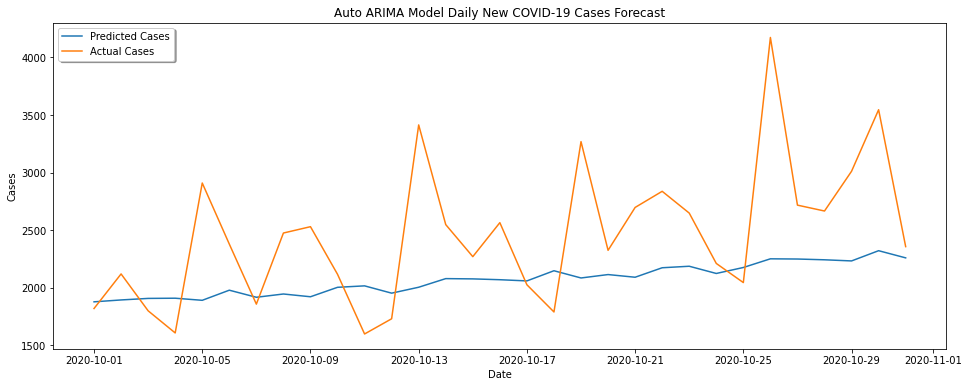

Mean Absolute Error Cases= 492.541
Accuracy 82.11%


In [ ]:
stepwise_model_cases.fit(train_cases['cases'])

forecast_aarima_cases = stepwise_model_cases.predict(n_periods=31)

# Create our forecast
forecast_aarima_cases = pd.DataFrame(forecast_aarima_cases, index = test_cases.index, columns=['Prediction'])
new_df = pd.concat([test_cases, forecast_aarima_cases], axis=1)
print(new_df)

plotARIMA(new_df, test_cases, 'Auto ARIMA Model Daily New COVID-19 Cases Forecast')

maeCasesDaily=mean_absolute_error(test_cases['cases'], new_df['Prediction'])
print('Mean Absolute Error Cases= %.3f' % maeCasesDaily)

auto_arima_daily_acc = getAccuracy(test_cases,new_df)

print('Accuracy %.2f%%' % (auto_arima_daily_acc))

In [ ]:
# AUTO ARIMA CASES WEEKLY BASE

# WE REMOVE THE SEASONAL NOW SINCE WE ARE TAKING PREDICTION ON WEEKLY BASIS INSTEAD OF WEEKLY
# Create model
stepwise_model_cases = auto_arima(df_cases_weekly['cases'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_cases.aic())

Fit ARIMA: order=(1, 1, 1); AIC=673.341, BIC=679.891, Fit time=0.121 seconds
Fit ARIMA: order=(0, 1, 0); AIC=691.954, BIC=695.229, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=671.475, BIC=676.388, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1); AIC=677.992, BIC=682.905, Fit time=0.017 seconds
Fit ARIMA: order=(2, 1, 0); AIC=673.317, BIC=679.867, Fit time=0.104 seconds
Fit ARIMA: order=(2, 1, 1); AIC=675.287, BIC=683.475, Fit time=0.147 seconds
Total fit time: 0.421 seconds
671.4753217750579


In [ ]:
# Create train/test data based on date

train_cases_weekly = df_cases_weekly[(df_cases_weekly.index > startDateTrain) & (df_cases_weekly.index <= endDateTrain)]

test_cases_weekly = df_cases_weekly[(df_cases_weekly.index >= startDateTest) & (df_cases_weekly.index <= endDateTest)]

stepwise_model_cases.fit(train_cases_weekly['cases'])

forecast_aarima_cases = stepwise_model_cases.predict(n_periods=4)

             cases  cumulative_cases    Prediction
date_report                                       
2020-10-04   13080           1140249  11294.496109
2020-10-11   15874           1245434  12362.770390
2020-10-18   16350           1357254  13137.684589
2020-10-25   18038           1479822  13756.755369


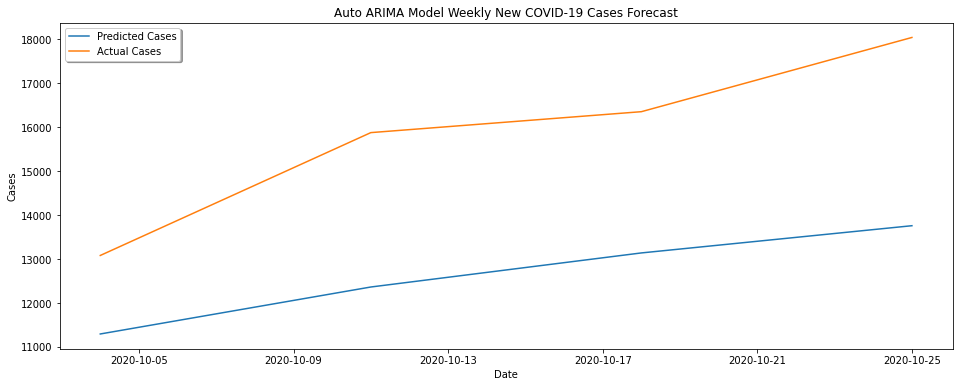

Mean Absolute Error Cases= 3197.573
Accuracy 80.21%


In [ ]:
# Create our forecast
forecast_aarima_cases = pd.DataFrame(forecast_aarima_cases, index = test_cases_weekly.index,columns=['Prediction'])
new_df = pd.concat([test_cases_weekly, forecast_aarima_cases], axis=1)
print(new_df)

plotARIMA(new_df, test_cases_weekly, 'Auto ARIMA Model Weekly New COVID-19 Cases Forecast')

maeCasesWeekly=mean_absolute_error(test_cases_weekly['cases'], new_df['Prediction'])
print('Mean Absolute Error Cases= %.3f' % maeCasesWeekly)

true_y_arr = test_cases_weekly['cases'].to_numpy()
pred_y_arr = new_df['Prediction'].to_numpy()
err_arr = []

auto_arima_weekly_acc = getAccuracy(test_cases_weekly,new_df)

print('Accuracy %.2f%%' % (auto_arima_weekly_acc))

In [ ]:
# fit model Autoregressive Integrated Moving Average
# Order of differencing required to make the series stationary
# transparams=True transform the parameters to ensure stationarity
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html
###
# classpmdarima.arima.ARIMA(order, seasonal_order=(0, 0, 0, 0), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=False, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=True, **sarimax_kwargs)
# season_order was not working with our version of ARIMA and so it had to be ommitted making the model not as acurate as desired
###
modelCases = ARIMA(seriesCases, order=(4, 0, 0)).fit(transparams=True, method='mle')
print(modelCases.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  206
Model:                     ARMA(4, 0)   Log Likelihood               -1410.123
Method:                           mle   S.D. of innovations            225.796
Date:                Sun, 06 Dec 2020   AIC                           2832.246
Time:                        04:45:29   BIC                           2852.213
Sample:                    03-09-2020   HQIC                          2840.322
                         - 09-30-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        846.6245    449.786      1.882      0.060     -34.939    1728.189
ar.L1.y        0.3198      0.069      4.668      0.000       0.186       0.454
ar.L2.y        0.1864      0.069      2.705      0.0

In [ ]:
# startDateTest = '2020-10-01'
# endDateTest = '2020-10-31'

ARIMA_Predict_Cases = modelCases.predict(start=startDateTest, end=endDateTest)

In [ ]:
# Root-mean-squared error and std dev
mseProphetCases = mean_squared_error(test_cases['cases'], forecastCasesNov['yhat'])
mseARIMACases = mean_squared_error(test_cases['cases'], ARIMA_Predict_Cases)
rmseProphetCases = sqrt(mseProphetCases)
rmseARIMACases = sqrt(mseARIMACases)

print('CASES DATA')
print('The MSE of ARIMA %.3f' % mseARIMACases)
print('The RMSE of ARIMA %.3f' % rmseARIMACases)
print('The MSE of Prophet %.3f' % mseProphetCases)
print('The RMSE of Prophet %.3f' % rmseProphetCases)

CASES DATA
The MSE of ARIMA 1029753.375
The RMSE of ARIMA 1014.768
The MSE of Prophet 2556101.307
The RMSE of Prophet 1598.781


2020-10-01    1817.730337
2020-10-02    1823.371698
2020-10-03    1767.968733
2020-10-04    1777.567551
2020-10-05    1772.266038
2020-10-06    1757.123301
2020-10-07    1744.395709
2020-10-08    1737.632486
2020-10-09    1727.733829
2020-10-10    1716.927027
2020-10-11    1707.415283
2020-10-12    1698.275302
2020-10-13    1688.680232
2020-10-14    1679.229053
2020-10-15    1670.074864
2020-10-16    1660.974339
2020-10-17    1651.908725
2020-10-18    1642.976467
2020-10-19    1634.161116
2020-10-20    1625.427636
2020-10-21    1616.787297
2020-10-22    1608.249609
2020-10-23    1599.806569
2020-10-24    1591.454551
2020-10-25    1583.195666
2020-10-26    1575.029235
2020-10-27    1566.952969
2020-10-28    1558.965993
2020-10-29    1551.067771
2020-10-30    1543.257181
2020-10-31    1535.533105
Freq: D, dtype: float64


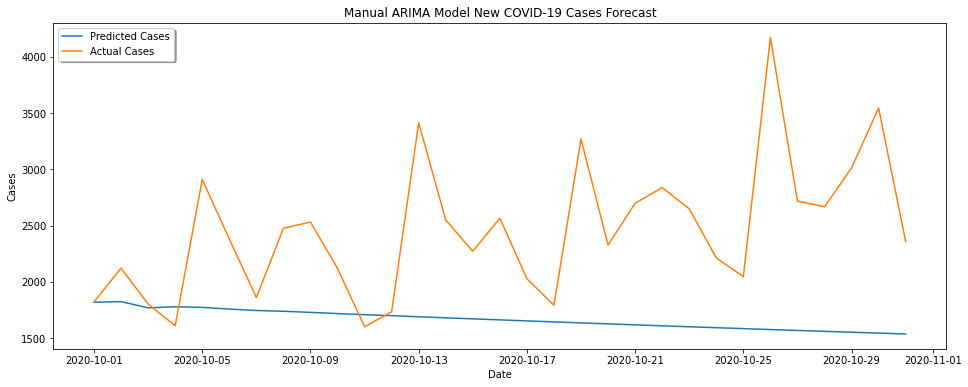

In [ ]:
# Plot prediction vs actual\
print(ARIMA_Predict_Cases)

plotARIMA(ARIMA_Predict_Cases, test_cases, 'Manual ARIMA Model New COVID-19 Cases Forecast')

In [ ]:
print('AUTO ARIMA models WITH daily and weekly seasonability\n')

print('Mean Absolute Error DAILY Cases= %.3f' % maeCasesDaily)
print('New Cases DAILY Accuracy %.2f%%' % (auto_arima_daily_acc))

print('\nMean Absolute Error WEEKLY Cases= %.3f' % maeCasesWeekly)
print('New Cases WEEKLY Accuracy %.2f%%' % (auto_arima_weekly_acc))

print('\n\n\nMANUAL ARIMA models WITHOUT daily and weekly seasonability\n')

true_y_arr = test_cases['cases'].to_numpy()
pred_y_arr = ARIMA_Predict_Cases.to_numpy()
err_arr = []

for i in range(len(true_y_arr)):
  err_arr.append(np.abs(true_y_arr[i] - pred_y_arr[i])/true_y_arr[i])

manual_arima_daily_acc = (1 - np.average(err_arr))*100

print('New Cases DAILY Accuracy %.2f%%' % (manual_arima_daily_acc))

maeCasesDailyManual=mean_absolute_error(test_cases['cases'], ARIMA_Predict_Cases)
print('Mean Absolute Error DAILY Cases= %.3f' % maeCasesDailyManual)


print('\n\n\nProphet model\n')


maeCasesProphet=mean_absolute_error(test_cases['cases'], forecastCasesNov['yhat'])
print('New Cases Daily Accuracy %.2f%%' % (prophet_acc))
print('Mean Absolute Error Cases = %.3f' % maeCasesProphet)



AUTO ARIMA models WITH daily and weekly seasonability

Mean Absolute Error DAILY Cases= 402.478
New Cases DAILY Accuracy 83.26%

Mean Absolute Error WEEKLY Cases= 3197.573
New Cases WEEKLY Accuracy 80.21%



MANUAL ARIMA models WITHOUT daily and weekly seasonability

New Cases DAILY Accuracy 70.96%
Mean Absolute Error DAILY Cases= 806.704



Prophet model

New Cases Daily Accuracy 40.84%
Mean Absolute Error Cases = 1507.683


Y = -1128.3 + 88.346X


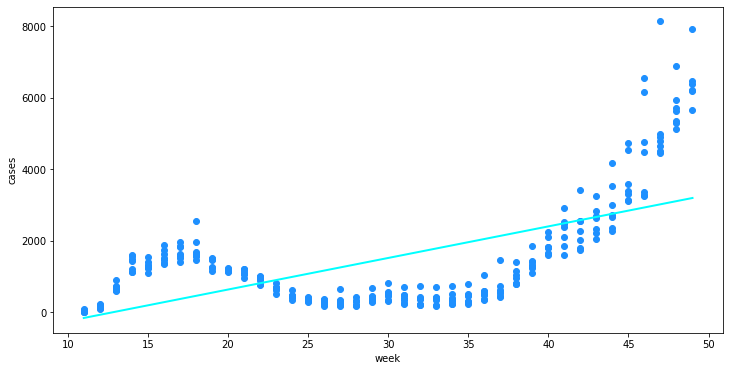

In [ ]:
from sklearn.linear_model import LinearRegression
X2 = df_cases['week'].values.reshape(-1,1)
y2 = df_cases['cases'].values.reshape(-1,1)
ir2 = LinearRegression()
ir2.fit(X2, y2)
predictions = ir2.predict(X2)
print("Y = {:.5} + {:.5}X".format(ir2.intercept_[0], ir2.coef_[0][0]))
plt.figure(figsize=(12, 6))
plt.scatter(X2,y2,c='dodgerblue')
plt.plot(X2,predictions,c='aqua',linewidth=2)
plt.xlabel("week")
plt.ylabel("cases")
plt.show()

Y = -952.4 + 45.08X


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



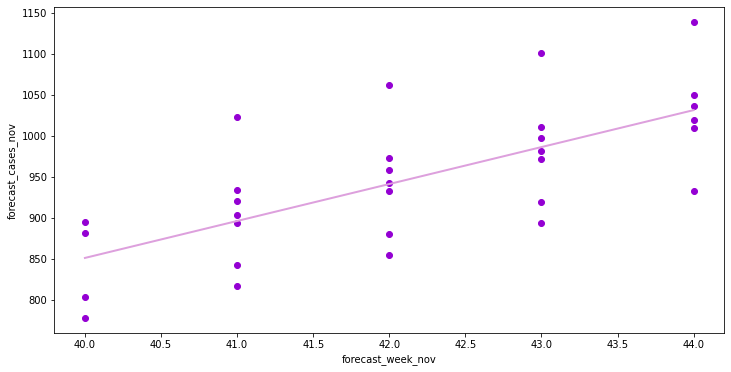

In [ ]:
forecastCasesNov['week']=forecastCasesNov['ds'].dt.week
X3 = forecastCasesNov['week'].values.reshape(-1,1)
y3 = forecastCasesNov['yhat'].values.reshape(-1,1)

ir3 = LinearRegression()
ir3.fit(X3, y3)
predictions = ir3.predict(X3)
print("Y = {:.5} + {:.5}X".format(ir3.intercept_[0], ir3.coef_[0][0]))
plt.figure(figsize=(12, 6))
plt.scatter(X3,y3,c='darkviolet')
plt.plot(X3,predictions,c='plum',linewidth=2)
plt.xlabel("forecast_week_nov")
plt.ylabel("forecast_cases_nov")
plt.show()

In [ ]:
# Temperature and wind oct 2020
startDateTrain = '2020-09-30'
endDateTrain = '2020-10-31'

df_temp = pd.read_csv('/content/TemperatureOct2020.csv')
df_temp['Date'] = pd.to_datetime(df_temp['Date'], dayfirst=True)

df_temp = df_temp[(df_temp['Date']> startDateTrain)]
df_temp_daily = df_temp.groupby(pd.Grouper(key='Date', freq='D')).sum()

X_train_temp = df_temp_daily.index
y_train_temp = df_temp_daily['TemperatureAvg']
y_train_wind= df_temp_daily['WindSpeedAvg']

print(X_train_temp)
print(y_train_temp)
print(y_train_wind)

DatetimeIndex(['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
               '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
               '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30', '2020-10-31'],
              dtype='datetime64[ns]', name='Date', freq='D')
Date
2020-10-01    57.0
2020-10-02    51.9
2020-10-03    49.3
2020-10-04    51.4
2020-10-05    54.7
2020-10-06    57.1
2020-10-07    56.2
2020-10-08    44.7
2020-10-09    47.2
2020-10-10    61.9
2020-10-11    44.3
2020-10-12    48.1
2020-10-13    50.2
2020-10-14    50.8
2020-10-15    57.0
2020-10-16    50.2
2020-10-17    47.4
2020-10-18    51.9
2020-10-19    50.7
2020-10-20    47.3

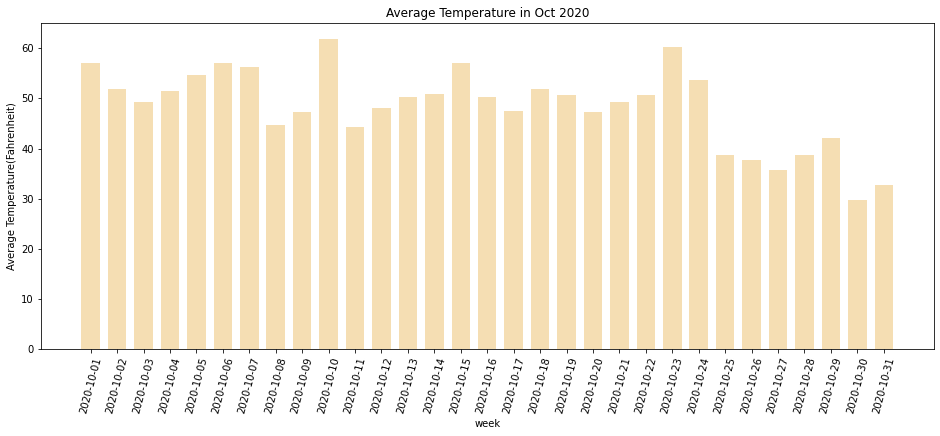

In [ ]:
#Visualize the data for reach data type
plt.figure(figsize=(16,6))
plt.bar(X_train_temp, y_train_temp, width=0.7, color='wheat')
plt.xticks(X_train_temp, X_train_temp.strftime("%Y-%m-%d"), rotation=75)
plt.title('Average Temperature in Oct 2020') 
plt.xlabel('week', size=10)
plt.ylabel('Average Temperature(Fahrenheit)', size=10)
plt.show()

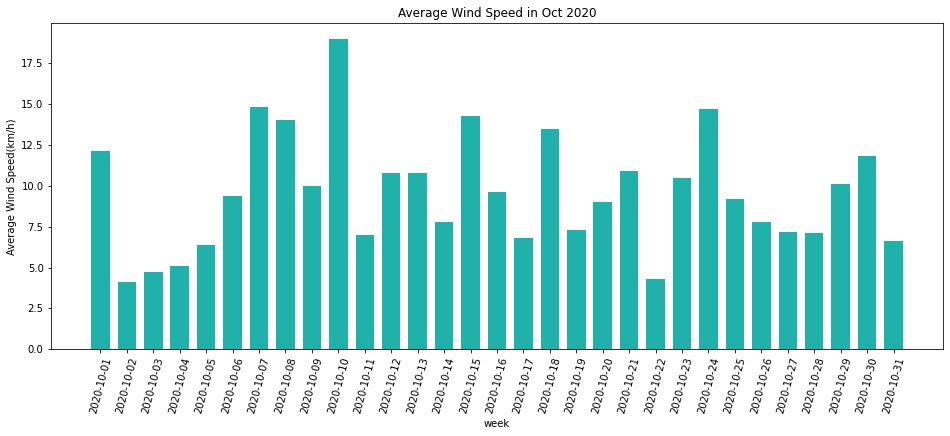

In [ ]:
#Visualize the data for reach data type
plt.figure(figsize=(16,6))
plt.bar(X_train_temp, y_train_wind, width=0.7, color='lightseagreen')
plt.xticks(X_train_temp, X_train_temp.strftime("%Y-%m-%d"), rotation=75)
plt.title('Average Wind Speed in Oct 2020') 
plt.xlabel('week', size=10)
plt.ylabel('Average Wind Speed(km/h)', size=10)
plt.show()